# Findings
- Overall better performance when training on split_1 (lower loss and higher accuracy) (perhaps not significant)

# Functions

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [34]:
def l2d_old(line):
    return " ".join(line.split()).split(" ")

def l2d(line):
    name = (line.split("  ")) # split on double whitespace
    name = next(sub for sub in name if sub) # fetch first non-empty cell
    name = name.strip() # remove whitespace from string
    
    metrics = (" ".join(line.split()).split(" ")[-4:])
    return ([name]+metrics)

def parse_classification_report(path):
    class_m = {}
    tot_m = {}
    
    if "teacher" in path:
        model = "teacher"
    else:
        model = "student"
    
    with open(path) as file:
        line = file.readline()
        line = file.readline() # skip first line
        line = file.readline()
        while line:
            data = l2d(line)
            
            class_m[data[0]] = {
                "prec": float(data[1]),
                "rec": float(data[2]),
                "f1": float(data[3]),
                "model": model
            }
            line = file.readline()

            if len(line) == 1:
                line = False
                
        line = file.readline()
        tot_m["acc"] = l2d_old(line)[1]
        line = file.readline()
        tot_m["macro"] = l2d_old(line)[2:5]
        line = file.readline()
        tot_m["weighted"] = l2d_old(line)[2:5]
                
    return class_m, tot_m

# _, tot_m = parse_classification_report(report_file)

In [36]:
import ast

def parse_history(path):
    with open(path) as file:
        # loss - acc - val_los - val_acc
        loss = file.readline()
        acc = file.readline()
        val_loss = file.readline()
        val_acc = file.readline()
        
        history = {
            "loss": ast.literal_eval(loss.split(":")[-1].strip()),
            "acc": ast.literal_eval(acc.split(":")[-1].strip()),
            "val_loss": ast.literal_eval(val_loss.split(":")[-1].strip()),
            "val_acc": ast.literal_eval(val_acc.split(":")[-1].strip())
        }
        
        return history

In [37]:
def savefig(name):
    plt.savefig("figures/nshypkva_"+name+".pdf", format="pdf")

In [38]:
def average_history(history_list):
    
    result = [0]*int(len(history_list[0]))
    for history in (history_list):
        for idx, val in enumerate(history):
            result[idx] += val
            
    result = [res/(len(history_list)) for res in result]
    return (result)

## Get the data from experiment results

In [98]:
exp_dir = "/home/henriklg/master-thesis/code/hyper-kvasir/experiments/ex3/cl_1000"
split0 = exp_dir+"/split0"
split1 = exp_dir+"/split1"

sub_dirs = ["0_teacher", "0_student", "1_teacher", "1_student", "2_teacher", "2_student"]

mets = ["loss", "acc", "val_loss", "val_acc"]
hist0 = {key: [] for key in mets}
hist1 = {key: [] for key in mets}

lowest_epoch = 200
for hist, split in zip([hist0, hist1], [split0, split1]):
    for dir_ in sub_dirs:
        path = "{}/{}/history.txt".format(split, dir_)
        history = parse_history(path)
    
        hist["loss"].append(history["loss"])
        hist["acc"].append(history["acc"])
        hist["val_loss"].append(history["val_loss"])
        hist["val_acc"].append(history["val_acc"])

        if (len(history["loss"]) < lowest_epoch):
            lowest_epoch = len(history["loss"])
            
# Shorten the history lists to the lowest epoch
for hist in [hist0, hist1]:
    for key, outerlist in hist.items():
        hist[key] = [sublist[0:lowest_epoch] for sublist in outerlist]

# Get results from training on split_0

### Accuracy and loss

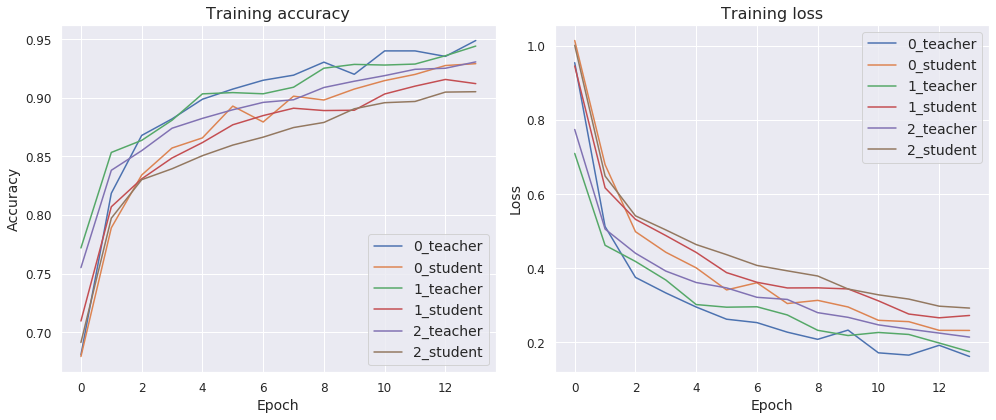

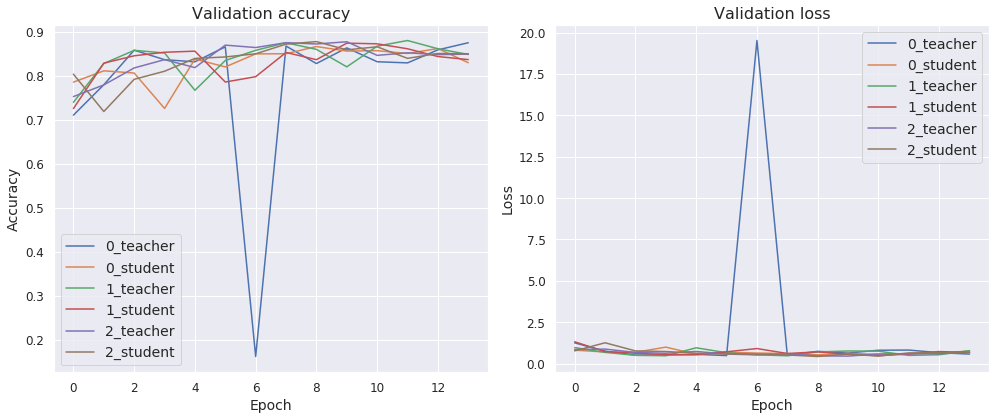

In [100]:
x = range(lowest_epoch)

plt.figure(figsize=(14,6));
# Subplot 1
plt.subplot(1, 2, 1)
for model in hist0["acc"]:
    plt.plot(x, model, linewidth=1.5)
plt.legend(sub_dirs);
plt.xlabel("Epoch")
plt.ylabel("Accuracy");
plt.title('Training accuracy')
plt.tight_layout()

# Subplot 2
plt.subplot(1, 2, 2)
for model in hist0["loss"]:
    plt.plot(x, model, linewidth=1.5)
plt.legend(sub_dirs);
plt.xlabel("Epoch")
plt.ylabel("Loss");
plt.tight_layout()
plt.title('Training loss')
savefig("history_training")


plt.figure(figsize=(14,6));
# Subplot 1
plt.subplot(1, 2, 1)
for model in hist0["val_acc"]:
    plt.plot(x, model, linewidth=1.5)
plt.legend(sub_dirs);
plt.xlabel("Epoch")
plt.ylabel("Accuracy");
plt.title('Validation accuracy')
plt.tight_layout()

# Subplot 2
plt.subplot(1, 2, 2)
for model in hist0["val_loss"]:
    plt.plot(x, model, linewidth=1.5)
plt.legend(sub_dirs);
plt.xlabel("Epoch")
plt.ylabel("Loss");
plt.tight_layout()
plt.title('Validation loss')
savefig("history_validation_split0")

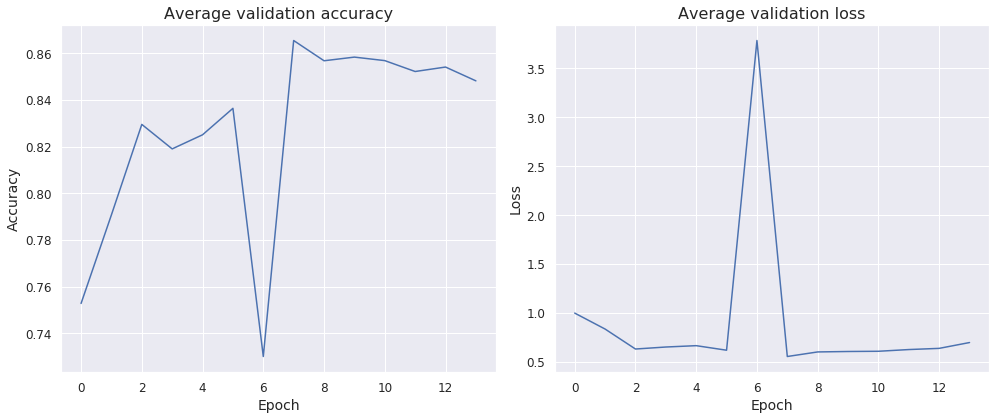

In [101]:
avg_val_acc_0 = average_history(hist0["val_acc"])
avg_val_loss_0 = average_history(hist0["val_loss"])

plt.figure(figsize=(14,6));
# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(x, avg_val_acc_0, linewidth=1.5)
plt.xlabel("Epoch")
plt.ylabel("Accuracy");
plt.title('Average validation accuracy')
plt.tight_layout()

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(x, avg_val_loss_0, linewidth=1.5)
plt.xlabel("Epoch")
plt.ylabel("Loss");
plt.tight_layout()
plt.title('Average validation loss')
savefig("history_average_validation_split0")

### F1-measure

In [15]:
report_contents_0 = []

for model in sub_dirs:
    report_file = "{}/{}/classification_report.txt".format(split0, model)
    
    _, tot_m = parse_classification_report(report_file)
    report_contents_0.append(tot_m);

In [102]:
# Compare weighted and macro precision, recall and f1-score
metrics0 = {
    "prec": [],
    "rec": [],
    "f1": [],
    "acc": []
}

metric = "weighted"

for idx, content in enumerate(report_contents_0):
    metrics0["acc"].append(float(content["acc"]))
    metrics0["prec"].append(float(content[metric][0]))
    metrics0["rec"].append(float(content[metric][1]))
    metrics0["f1"].append(float(content[metric][2]))

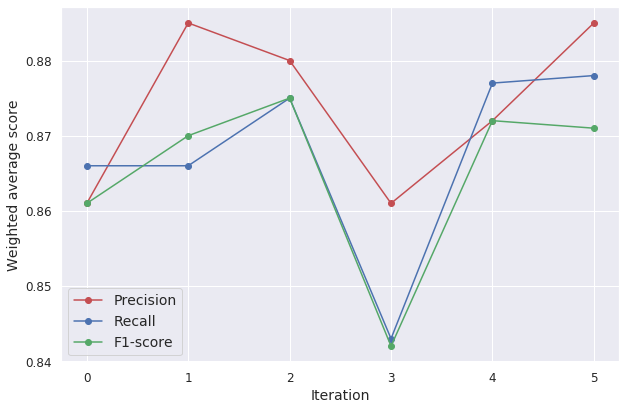

In [103]:
x = list(range(len(sub_dirs)))

plt.figure(figsize=(9,6))
plt.plot(
    x,metrics0["prec"],'r', 
    x,metrics0["rec"],'b', 
    x,metrics0["f1"],'g', 
    linewidth=1.5, marker='o'
)
plt.legend(["Precision","Recall","F1-score", "acc"])
plt.xlabel("Iteration")
plt.ylabel("Weighted average score")
plt.tight_layout(pad=1.5)
savefig("prec_rec_f1_split0.pdf")

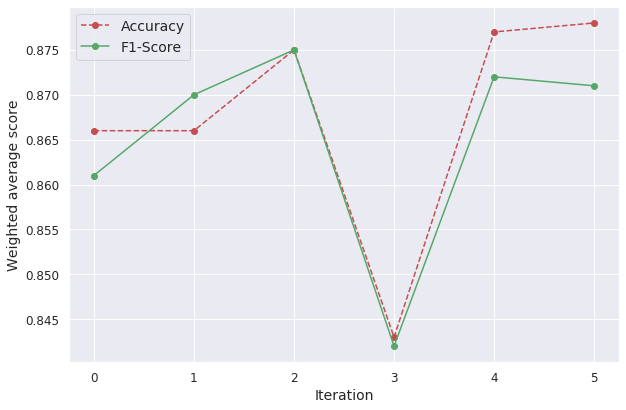

In [104]:
plt.figure(figsize=(9,6))
plt.plot(
    x,metrics0["acc"],'r--', 
    x,metrics0["f1"],'g-', 
    linewidth=1.5, marker='o'
)
plt.legend(["Accuracy", "F1-Score"])
plt.xlabel("Iteration")
plt.ylabel("Weighted average score")
plt.tight_layout(pad=1.5)

# Get results from training on split_1

### Accuracy and loss

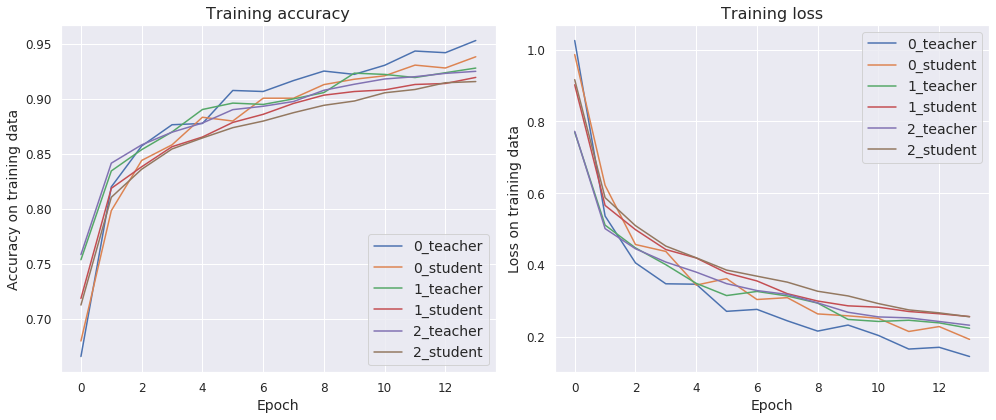

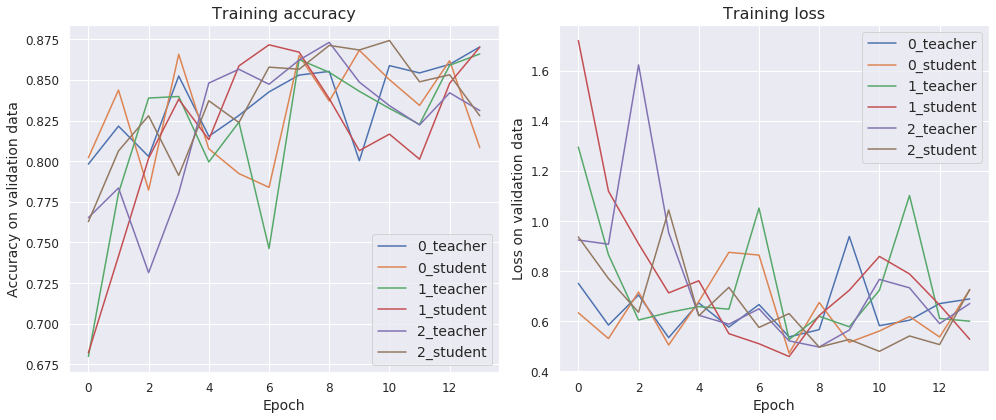

In [106]:
x = range(lowest_epoch)

plt.figure(figsize=(14,6));
# Subplot 1
plt.subplot(1, 2, 1)
for model in hist1["acc"]:
    plt.plot(x, model, linewidth=1.5)
plt.legend(sub_dirs);
plt.xlabel("Epoch")
plt.ylabel("Accuracy on training data");
plt.title('Training accuracy')
plt.tight_layout()

# Subplot 2
plt.subplot(1, 2, 2)
for model in hist1["loss"]:
    plt.plot(x, model, linewidth=1.5)
plt.legend(sub_dirs);
plt.xlabel("Epoch")
plt.ylabel("Loss on training data");
plt.tight_layout()
plt.title('Training loss')
savefig("history_training")


plt.figure(figsize=(14,6));
# Subplot 1
plt.subplot(1, 2, 1)
for model in hist1["val_acc"]:
    plt.plot(x, model, linewidth=1.5)
plt.legend(sub_dirs);
plt.xlabel("Epoch")
plt.ylabel("Accuracy on validation data");
plt.title('Training accuracy')
plt.tight_layout()

# Subplot 2
plt.subplot(1, 2, 2)
for model in hist1["val_loss"]:
    plt.plot(x, model, linewidth=1.5)
plt.legend(sub_dirs);
plt.xlabel("Epoch")
plt.ylabel("Loss on validation data");
plt.tight_layout()
plt.title('Training loss')
savefig("history_validation_split1")

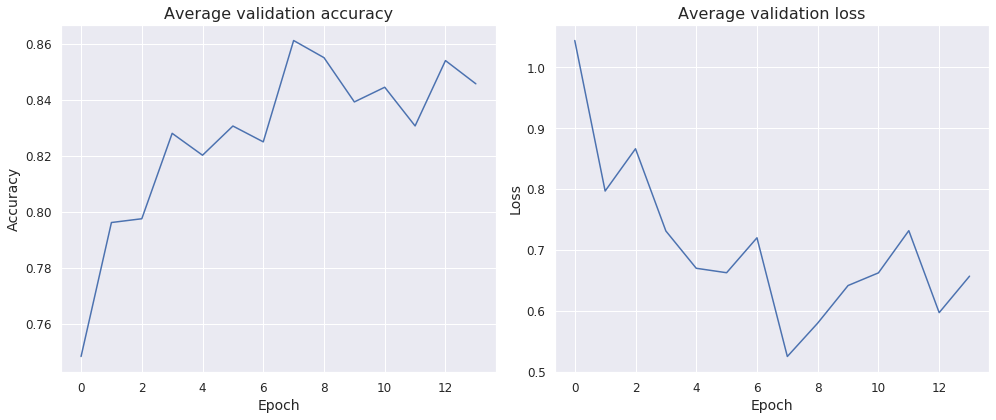

In [107]:
avg_val_acc_1 = average_history(hist1["val_acc"])
avg_val_loss_1 = average_history(hist1["val_loss"])

plt.figure(figsize=(14,6));
# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(x, avg_val_acc_1, linewidth=1.5)
plt.xlabel("Epoch")
plt.ylabel("Accuracy");
plt.title('Average validation accuracy')
plt.tight_layout()

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(x, avg_val_loss_1, linewidth=1.5)
plt.xlabel("Epoch")
plt.ylabel("Loss");
plt.tight_layout()
plt.title('Average validation loss')
savefig("history_average_validation_split1")

### F1-measure

In [25]:
report_contents_1 = []

for model in sub_dirs:
    report_file = "{}/{}/classification_report.txt".format(exp_dir_split1, model)
    
    _, tot_m = parse_classification_report(report_file)
    report_contents_1.append(tot_m);

In [109]:
# Compare weighted and macro precision, recall and f1-score
metrics1 = {
    "prec": [],
    "rec": [],
    "f1": [],
    "acc": []
}

metric = "weighted"

for idx, content in enumerate(report_contents_1):
    metrics1["acc"].append(float(content["acc"]))
    metrics1["prec"].append(float(content[metric][0]))
    metrics1["rec"].append(float(content[metric][1]))
    metrics1["f1"].append(float(content[metric][2]))

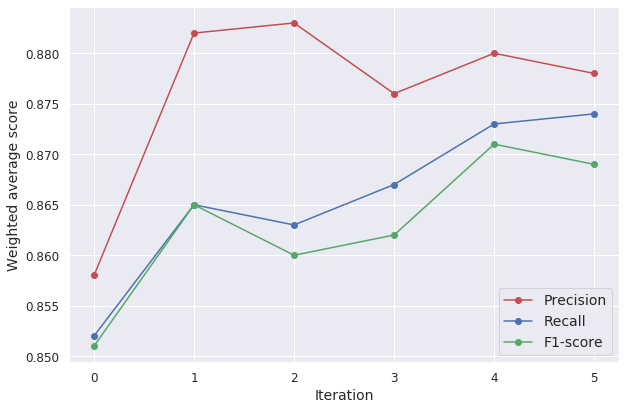

In [110]:
x = list(range(len(sub_dirs)))

plt.figure(figsize=(9,6))
plt.plot(
    x,metrics1["prec"],'r', 
    x,metrics1["rec"],'b', 
    x,metrics1["f1"],'g', 
    linewidth=1.5, marker='o'
)
plt.legend(["Precision","Recall","F1-score", "acc"])
plt.xlabel("Iteration")
plt.ylabel("Weighted average score")
plt.tight_layout(pad=1.5)
savefig("prec_rec_f1_split1.pdf")

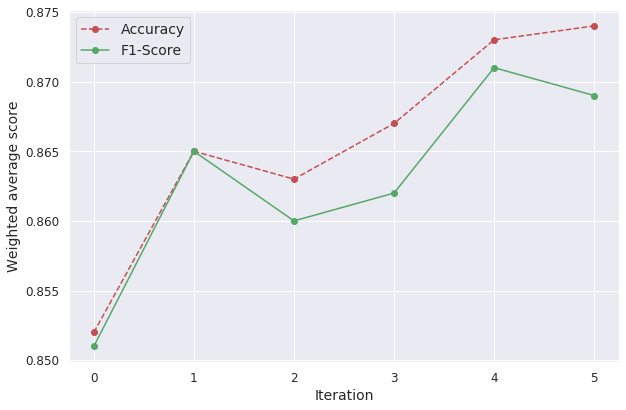

In [119]:
plt.figure(figsize=(9,6))
plt.plot(
    x,metrics1["acc"],'r--', 
    x,metrics1["f1"],'g-', 
    linewidth=1.5, marker='o'
)
plt.legend(["Accuracy", "F1-Score"])
plt.xlabel("Iteration")
plt.ylabel("Weighted average score")
plt.tight_layout(pad=1.5)

# Average the results of both splits

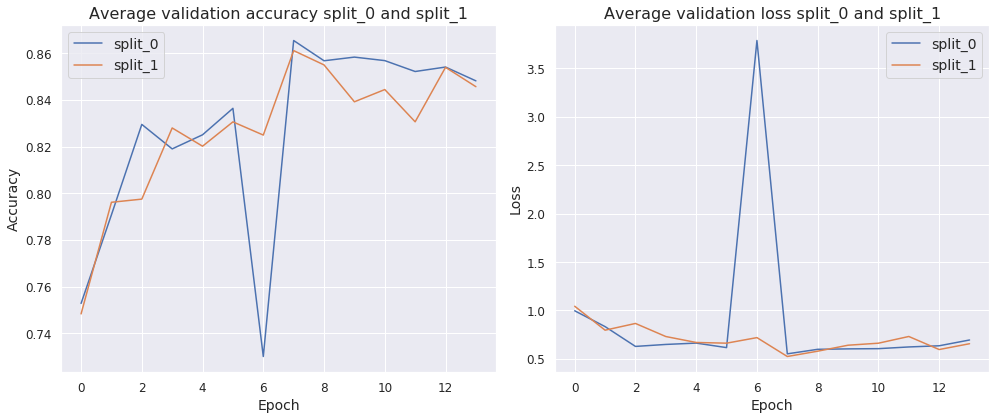

In [112]:
x = range(lowest_epoch)

plt.figure(figsize=(14,6));
# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(
    x, avg_val_acc_0, 
    x, avg_val_acc_1, 
    linewidth=1.5
)
plt.legend(["split_0", "split_1"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy");
plt.title('Average validation accuracy split_0 and split_1')
plt.tight_layout()

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(
    x, avg_val_loss_0, 
    x, avg_val_loss_1, 
    linewidth=1.5
)
plt.legend(["split_0", "split_1"])
plt.xlabel("Epoch")
plt.ylabel("Loss");
plt.tight_layout()
plt.title('Average validation loss split_0 and split_1')
savefig("history_average_validation_both_splits")

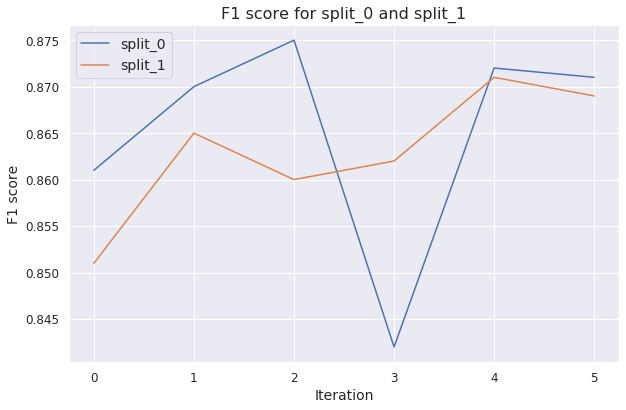

In [118]:
x = range(len(sub_dirs))

plt.figure(figsize=(9,6))
plt.plot(
    x, metrics0["f1"],
    x, metrics1["f1"], 
    linewidth=1.5
)
plt.legend(["split_0", "split_1"])
plt.title("F1 score for split_0 and split_1")
plt.xlabel("Iteration")
plt.ylabel("F1 score")
plt.tight_layout(pad=1.5)

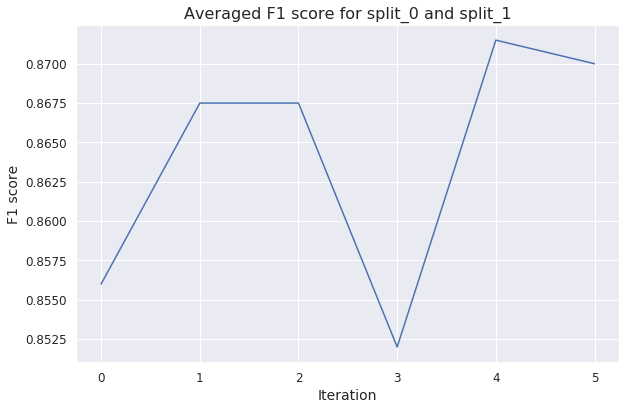

In [117]:
average_f1 = average_history([metrics0["f1"], metrics1["f1"]])

plt.figure(figsize=(9,6))
plt.plot(
    x, average_f1,
    linewidth=1.5
)
# fig = plt.legend(["split_0", "split_1"])
plt.title("Averaged F1 score for split_0 and split_1")
fig = plt.xlabel("Iteration")
fig = plt.ylabel("F1 score")
plt.tight_layout(pad=1.5)

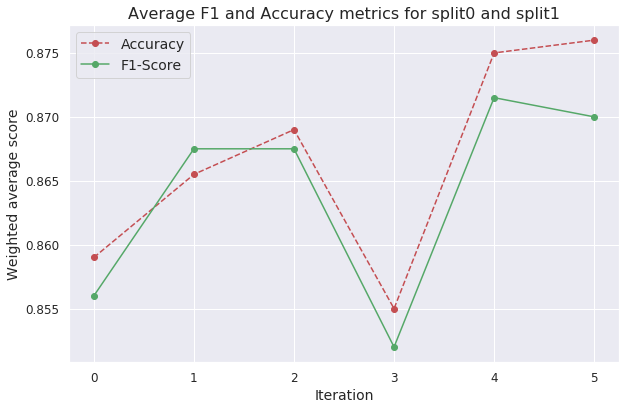

In [121]:
average_acc = average_history([metrics0["acc"], metrics1["acc"]])

plt.figure(figsize=(9,6))
plt.plot(
    x,average_acc,'r--', 
    x,average_f1,'g-', 
    linewidth=1.5, marker='o'
)
plt.legend(["Accuracy", "F1-Score"])
plt.title("Average F1 and Accuracy metrics for split0 and split1")
plt.xlabel("Iteration")
plt.ylabel("Weighted average score")
plt.tight_layout(pad=1.5)